# Replication of Carneiro, Heckman, & Vytlacil's (2011) *Local Instrumental Variables* approach

In this notebook, I reproduce the semiparametric results from

> Carneiro, P., Heckman, J. J., & Vytlacil, E. J. (2011). [Estimating marginal returns to education.](https://pubs.aeaweb.org/doi/pdfplus/10.1257/aer.101.6.2754) *American Economic Review, 101*(6), 2754-81. 

The goal of this endeavor is to add the semiparametric estimation method to the open-source package *grmpy* for the simulation and estimation of the generalized Roy model in Python. Currently, *grmpy* is limited to the estimation of a parametric normal version of the generalized Roy model. <br> For more, see the [online documentation](https://grmpy.readthedocs.io/en/develop/). 

This notebook makes use of the replication material provided by [Carneiro et al. (2011)](https://pubs.aeaweb.org/doi/pdfplus/10.1257/aer.101.6.2754).

In [1]:
import pandas as pd
import numpy as np
import warnings
import math

import matplotlib.patches as mpatches
import matplotlib.pyplot as plt

from grmpy.check.check import check_presence_estimation_dataset
from grmpy.check.check import check_initialization_dict
from grmpy.check.check import check_presence_init
from grmpy.check.auxiliary import read_data
from grmpy.read.read import read

from semipar.estimation.estimate_auxiliary import estimate_treatment_propensity
from semipar.estimation.estimate_auxiliary import define_common_support
from semipar.estimation.estimate_auxiliary import double_residual_reg
from semipar.estimation.estimate_auxiliary import construct_Xp
from semipar.estimation.estimate_auxiliary import trim_data

from semipar.estimation.estimate import semipar_fit
from semipar.KernReg.locpoly import locpoly
from hackathon_auxiliary import bootstrap
from sklearn.utils import resample
from scipy.stats import norm

warnings.filterwarnings('ignore')

Since the replication material does not contain geographic identifiers, we are unable to merge the separate data files in such a way to accurately recreate the original data set. Therefore, we need to create a mock data set where indivudal specific data and local characteristics are merged arbitrarily (note, however, that the basic and local data are merged the same way each time, so we always work with the same mock data set).

In [2]:
# Data preparation
def process_mock_df(df, output_file):
    """This function adds squared and interaction terms to the Carneiro data set."""

    # Delete redundant columns\n",
    for key_ in ["newid", "caseid"]:
        del df[key_]

    # Add squared terms
    for key_ in ["mhgc", "cafqt", "avurate", "lurate_17", "numsibs", "lavlocwage17"]:
        str_ = key_ + "sq"
        df[str_] = df[key_] ** 2

    # Add interaction terms
    for j in ["pub4", "lwage5_17", "lurate_17", "tuit4c"]:
        for i in ["cafqt", "mhgc", "numsibs"]:
            df[j + i] = df[j] * df[i]
    
    # save output_file
    df.to_pickle(output_file + ".pkl")

In [3]:
basic = pd.read_stata('semipar/data/basicvariables.dta')
local = pd.read_stata('semipar/data/localvariables.dta')
df = pd.concat([basic, local], axis = 1)
process_mock_df(df,'semipar/data/aer-replication-mock')

In [4]:
# Replicate the results from Carneiro et al. (2011) using the mock data set created above.
quantiles, mte_u, mte_x, mte = semipar_fit("semipar/files/replication.bootstrap.yml")
mte_4 = mte / 4

Note that the MTEs are divided by 4 to get an estimate of the benefits of one 
additional year of college education rather than the benefits of obtaining a 4-year college degree.

Following Carneiro et al. (2011), I compute 90 percent confidence intervals using bootstrapped standard errors (250 iterations). 

First, draw $B = 250$ independent bootstrap samples and compute the *MTE* $ \ \hat{\theta}^{MTE}(b)$ for each bootstrap replication $b = 1,..,B$. 

In [5]:
# Draw bootstraps and calculate MTE estimates.
nbootstraps = 250
mte_boot = bootstrap('semipar/files/replication.bootstrap.yml', nbootstraps)

Second, estimate the standard error of $\hat{\theta}^{MTE}$, denoted by $\widehat{\mathbf{se}}_B$, separately for each gridpoint $u_D$:

$$ \widehat{\mathbf{se}}_B = \frac{1}{B-1} \sum_{b = 1}^{B}{\{ \hat{\theta}}^{MTE}(b) \ - \ \hat{\theta}^{MTE}(\cdot)    \}^2 $$

where $\hat{\theta}^{MTE}(\cdot)$ is the replicated *MTE* of the baseline data set.

In [6]:
mte_boot = mte_boot / 4

# Get standard error of MTE at each gridpoint u_D
mte_boot_std = np.std(mte_boot, axis=1)

# Compute 90 percent confidence intervals
con_u = mte_4 + norm.ppf(0.95) * mte_boot_std
con_d = mte_4 - norm.ppf(0.95) * mte_boot_std

In [7]:
# import original results
mte_ = pd.read_csv('semipar/data/mte_semipar_original.csv')

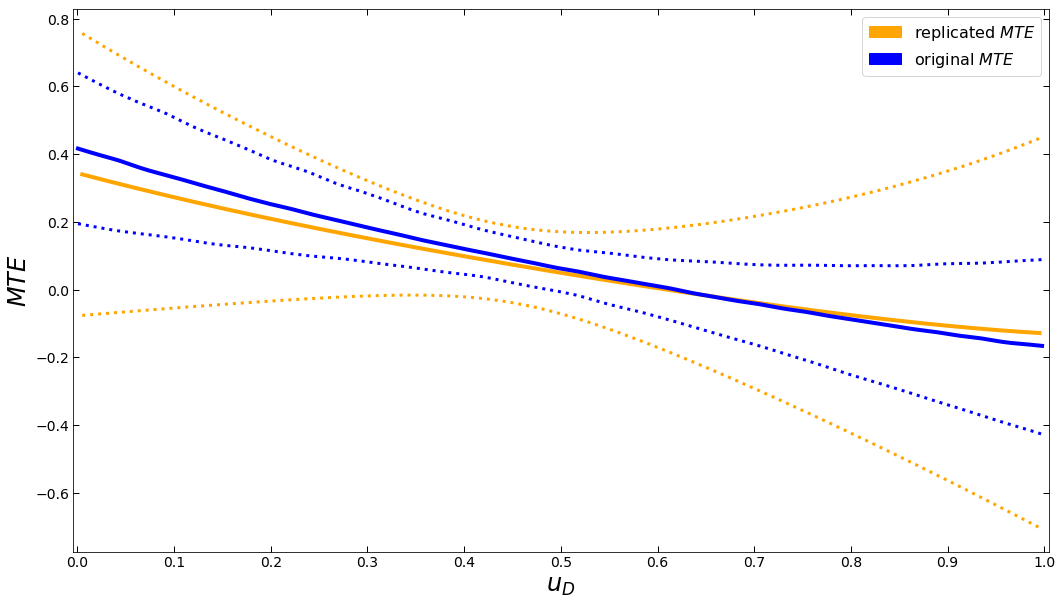

In [8]:
# Plot
ax = plt.figure(figsize=(17.5, 10)).add_subplot(111)

ax.set_ylabel(r"$MTE$", fontsize=24)
ax.set_xlabel("$u_D$", fontsize=24)
ax.tick_params(axis="both" ,direction='in', length=6, width=1, grid_alpha=0.25, labelsize=14)
ax.xaxis.set_ticks_position('both')
ax.yaxis.set_ticks_position('both')
ax.xaxis.set_ticks(np.arange(0, 1.1, step=0.1))
ax.yaxis.set_ticks(np.arange(-1.8, 0.9, step=0.2))

# Plot replicated curves
ax.plot(quantiles, mte_4, label="replicated $MTE$", color="orange", linewidth=4)
ax.plot(quantiles, con_u, color="orange", linestyle=":", linewidth=3)
ax.plot(quantiles, con_d, color="orange", linestyle=":", linewidth=3)


# Plot original curve
ax.plot(mte_['quantiles'], mte_['mte'], label="$original MTE$", color="blue", linewidth=4)
ax.plot(mte_['quantiles'], mte_['con_u'], color="blue", linestyle=":", linewidth=3)
ax.plot(mte_['quantiles'], mte_['con_d'], color="blue", linestyle=":", linewidth=3)

#ax.set_ylim([-0.51, 0.71])
ax.set_xlim([-0.005, 1.005])

blue_patch = mpatches.Patch(color="orange", label="replicated $MTE$")
orange_patch = mpatches.Patch(color="blue", label="original $MTE$")
plt.legend(handles=[blue_patch, orange_patch], prop={"size": 16})
plt.show()

People with the highest returns to education (those who have low unobserved resistance $u_D$
) are more likely to go to college. Note that the returns vary considerably with $u_D$
. Low $u_D$ students have returns of up to 40% per year of college, whereas high $u_D$
 people, who would loose from attending college, have returns of approximately - 15%.

Note that the 90 percent confidence bands of the replicated _MTE_ are wider. This is due to the use of a mock data set which merges personal and local variables randomly. In particular, combined with the utilization of techniques, this makes the semiparametric replication more sensitive than a parametric normal specification.